In [1]:
#from scripts.build_poincare_map.poincare_maps import *
#Load dependencies
import os
import numpy as np
import pandas as pd
import subprocess
import json
import warnings
warnings.filterwarnings('ignore')
import scipy


#Import visualization functions
from scripts.visualize_projection.pplots_new import read_embeddings, plot_embedding, plot_embedding_interactive, rotate, get_colors
%matplotlib inline
from poincare_maps import *
from embedding_quality_score import *

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA


from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
import plotly.express as px
import umap

In [2]:
from scripts.build_poincare_map.kmedoids import *
from sklearn import metrics

def get_scores(t_labels, labels):
    ARS = metrics.adjusted_rand_score(t_labels, labels)
    FMS = metrics.fowlkes_mallows_score(t_labels, labels)
    #print(f"ARI = {ARS:.2f}")
    #print(f"FMS = {FMS:.2f}")
    
    return ARS, FMS

def detect_cluster(D, n_clusters=2, clustering_name='spectral', k=5, class_exclude = "OTHER"): #distances='Poincaré',
    if clustering_name == 'spectral':
        similarity = np.exp(-D**2)
        clustering = SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack', 
                                        affinity='precomputed', n_neighbors=k).fit(similarity)
        labels = clustering.labels_
    elif clustering_name == 'kmedoids':
        clustering = kMedoids(D, n_clusters, tmax=10000)
        labels = clustering
    else:
        #clustering = AgglomerativeClustering(linkage='average', n_clusters=n_clusters, 
        #                                     affinity='precomputed').fit(D)
        clustering = AgglomerativeClustering(linkage='average', n_clusters=n_clusters, 
                                             affinity='precomputed').fit(D)
        labels = clustering.labels_
            
    return labels


def color_clusters(df, x, y, color):
    plt = px.scatter(df_tsne, x = x, y = y,
                     color = color,
                     color_discrete_map=kinase_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title
                 )
    fig.show()

In [3]:
knn = 5
gamma = 2
sigma = 1
cospca = 0
batchs = 4
epochs = 1000
seed = 0

out_name = "kinases_data"
path_annotation = "examples/kinases/kinase_group_new1.csv"
path_embedding = f"{out_name}/projections/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)
print(df_embedding)
df_embedding.replace("Other", "OTHER")

            proteins_id       pm1       pm2 1_Group    2_Gene      3_HGNC  \
proteins_id                                                                 
1                     1 -0.707558 -0.591890     AGC      AKT1    HGNC:391   
2                     2 -0.716056 -0.569460     AGC      AKT2    HGNC:392   
3                     3 -0.694581 -0.567775     AGC      AKT3    HGNC:393   
4                     4 -0.397540 -0.890217     AGC  CDC42BPA   HGNC:1737   
5                     5 -0.393420 -0.886927     AGC  CDC42BPB   HGNC:1738   
...                 ...       ...       ...     ...       ...         ...   
493                 493  0.499565  0.780303     TYR    TYK2_1  HGNC:12440   
494                 494  0.221907  0.866066     TYR    TYK2_2  HGNC:12440   
495                 495  0.304742  0.830562     TYR     TYRO3  HGNC:12446   
496                 496  0.401966  0.612660     TYR      YES1  HGNC:12841   
497                 497  0.469061  0.822273     TYR     ZAP70  HGNC:12858   

,proteins_id,pm1,pm2,1_Group,2_Gene,3_HGNC,4_Uni_entry,5_Uni_acc,6_Domain_begin,7_Domain_end,...,9_Largest_insert_length,10_PDB_validation,11_Conformational_state,12_Dihedral_state,13_Group_in_Uni,14_Group_in_Manning,15_Synonymn,evo_distance,decile_domain,small_cluster
proteins_id,,,,,,,,,,,,,,,,,,,,,
1,1,-0.707558,-0.591890,AGC,AKT1,HGNC:391,AKT1_HUMAN,P31749,150,408,...,9,6NPZB,DFGin,BLAminus,AGC,AGC,"PKB,RAC",1.208266,2,RAC
2,2,-0.716056,-0.569460,AGC,AKT2,HGNC:392,AKT2_HUMAN,P31751,152,409,...,9,3E8DB,DFGin,BLAminus,AGC,AGC,nan,1.208312,2,RAC
3,3,-0.694581,-0.567775,AGC,AKT3,HGNC:393,AKT3_HUMAN,Q9Y243,148,405,...,9,nan,nan,nan,AGC,AGC,PKBG,1.183463,2,RAC
4,4,-0.397540,-0.890217,AGC,CDC42BPA,HGNC:1737,MRCKA_HUMAN,Q5VT25,77,343,...,14,nan,nan,nan,AGC,AGC,KIAA0451,1.399119,5,DMPK
5,5,-0.393420,-0.886927,AGC,CDC42BPB,HGNC:1738,MRCKB_HUMAN,Q9Y5S2,76,342,...,14,5OTFA,DFGin,BLAminus,AGC,AGC,KIAA1124,1.406213,5,DMPK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,493,0.499565,0.780303,TYR,TYK2_1,HGNC:12440,TYK2_HUMAN,P29597,589,868,...,26,3ZONA,DFGin,nan,TYR,TYR,nan,2.924877,7,JAK
494,494,0.221907,0.866066,TYR,TYK2_2,HGNC:12440,TYK2_HUMAN,P29597,897,1171,...,21,4GVJA,DFGin,BLAminus,TYR,TYR,nan,2.031230,6,JAK
495,495,0.304742,0.830562,TYR,TYRO3,HGNC:12446,TYRO3_HUMAN,Q06418,518,788,...,10,nan,nan,nan,TYR,TYR,"BYK,DTK,RSE,SKY,TIF",2.428364,6,AXL/UFO


Labels and number of clusters:

In [ ]:
poincare_coord = pd.read_csv(path_embedding, sep=',').sort_values(by=["proteins_id"])
poincare_coord = poincare_coord.values[:,:2]
print(path_embedding)
model = PoincareMaps(poincare_coord)
model.get_distances()

In [ ]:
model.detect_cluster(n_clusters=nc, clustering_name='spectral', k=5)
df_embedding["poincare_clust"] = model.clusters
df_embedding["poincare_clust"] = df_embedding["poincare_clust"].astype("string")

In [ ]:
import plotly.express as px
fig = plot_embedding_interactive(df_embedding, 
                                 labels_name = "1_Group",
                                 #second_labels_name = second_labels_name, 
                                 #show_text = show_text,
                                 #labels_text = labels_text,
                                 color_palette = None, 
                                 #title = title, 
                                 fontsize = 11)
fig.show()

# Comparison of different scores for Poincaré vs other methods

## Kinases

In [4]:
n_proteins = df_embedding.shape[0]
x = np.array(np.loadtxt(out_name + "/fasta0.9/1.aamtx").reshape(-1))
len_prot = len(x)

features = np.zeros([n_proteins, len_prot])

for i in range(n_proteins):
    #print(out_name + "/fasta0.9/" + str(i) + ".aamtx")
    x = np.array(np.loadtxt(out_name + "/fasta0.9/" + str(i+1) + ".aamtx").reshape(-1))
    features[i,:] = x


In [5]:
# Construction of custom color palette 
kinase_palette = {-1 : "#c7c7c7", "OTHER": "#c7c7c7", "None" :"#c7c7c7", "NA" : "#c7c7c7", "Uncharacterized" : "#c7c7c7", "root": "#000000",
                  "TYR": "#bd065f", "CMGC": "#d5c203", "TKL": "#997e73","STE": "#80b412", # kinase groups 
                  "CK1": "#0dbae9", "AGC": "#00bba1", "CAMK":  "#1f6ed4", "NEK": "#8ce4fa", "RGC":"#f59a62"}

In [6]:
D_raw = pairwise_distances(features, metric="cosine")
print(features[0,:])
print(D_raw.shape)

[0.1225 0.0307 0.061  ... 0.0713 0.1938 0.3363]
(497, 497)


## Evaluate clustering

In [8]:
df_results_clust = pd.DataFrame()

In [15]:
true_col = "small_cluster"
#true_col = "1_Group"

other = "OTHERS"

remove_others = True
remove_outliers = True

expected_nc = df_embedding[true_col].unique().size
no_outliers = df_embedding[true_col].duplicated(keep=False)

nc = expected_nc
print("Number of expected classes: ", nc)
k_neigh = knn

print(expected_nc)
nc = expected_nc
k_neigh = knn
remove_others = True

Number of expected classes:  76
76


In [16]:
cname = 'agglomerative'
setting = "manifold" # "global" # 

for seed in range(5):
    # read poincare and annotations
    path_embedding = f"{out_name}/projections/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
    df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)
    df_embedding.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = df_embedding[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model = PoincareMaps(poincare_coord)
    model.get_distances()
    # poincare scores
    clusters = detect_cluster(model.distances, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_poincare"] = clusters
    df_embedding["clust_poincare"] = df_embedding["clust_poincare"].astype("string")
    # MDS scores
    X_cosine = pairwise_distances(features,metric='cosine')
    X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = seed).fit_transform(X_cosine)
    df_embedding["x1_mds"] = X_mds[:,0]
    df_embedding["x2_mds"] = X_mds[:,1]
    D = pairwise_distances(X_mds)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_mds"] = clusters
    df_embedding["clust_mds"] = df_embedding["clust_mds"].astype("string")
    # tSNE scores
    X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
    df_embedding["x1_tsne"] = X_tsne[:,0]
    df_embedding["x2_tsne"] = X_tsne[:,1]
    D = pairwise_distances(X_tsne)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_tsne"] = clusters
    df_embedding["clust_tsne"] = df_embedding["clust_tsne"].astype("string")
    # UMAP scores
    X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
    df_embedding["x1_umap"] = X_umap[:,0]
    df_embedding["x2_umap"] = X_umap[:,1]
    D = pairwise_distances(X_umap)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_umap"] = clusters
    df_embedding["clust_umap"] = df_embedding["clust_umap"].astype("string")
    # PCA scores
    X_pca = KernelPCA(kernel='cosine', random_state = seed).fit_transform(features)
    df_embedding["x1_pca"] = X_pca[:,0]
    df_embedding["x2_pca"] = X_pca[:,1]
    D = pairwise_distances(X_pca)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_pca"] = clusters
    df_embedding["clust_pca"] = df_embedding["clust_pca"].astype("string")
    
    # clustering
    if remove_outliers:
        df_noothers = df_embedding[no_outliers]
    if remove_others:
        df_noothers = df_noothers[df_embedding[true_col]!=other]
    
    for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:

        ARI, FMS = get_scores(df_noothers[true_col], df_noothers["clust_" + clust_meth])

        if clust_meth == "poincare":
            D = model.distances
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting=setting, k_neighbours=5)
        else:
            D = pairwise_distances(df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth])
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting=setting, k_neighbours=5)

        corr = scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0)
    
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "nc": [nc], "true_col": [true_col], "ARI": [ARI], "FMS": [FMS]})
        df_results_clust = df_results_clust.append(df)
        
        # print(df_Q.Qnx.to_numpy())
        
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "Kmax": [Kmax], "Qnx": [df_Q.Qnx.to_numpy()]})
        df_results_proj = df_results_proj.append(df)

#print(df_results)

Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4


In [33]:
fig = px.strip(df_results_clust, x='method', y='ARI', color = "true_col")
fig.update_yaxes(range = [0,1])
fig.show()

In [34]:
fig.write_image("ARI_kinases.pdf")

## Evaluate projection

In [36]:
df_results_proj = pd.DataFrame()

In [37]:
cname = 'agglomerative'
setting =   "manifold" # "global" #

for seed in range(5):
    # read poincare and annotations
    path_embedding = f"{out_name}/projections/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
    df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)
    df_embedding.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = df_embedding[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model = PoincareMaps(poincare_coord)
    model.get_distances()
    # MDS scores
    X_cosine = pairwise_distances(features,metric='cosine')
    X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = seed).fit_transform(X_cosine)
    df_embedding["x1_mds"] = X_mds[:,0]
    df_embedding["x2_mds"] = X_mds[:,1]
    # tSNE scores
    X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
    df_embedding["x1_tsne"] = X_tsne[:,0]
    df_embedding["x2_tsne"] = X_tsne[:,1]
    # UMAP scores
    X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
    df_embedding["x1_umap"] = X_umap[:,0]
    df_embedding["x2_umap"] = X_umap[:,1]
    # PCA scores
    X_pca = KernelPCA(kernel='cosine', random_state = seed).fit_transform(features)
    df_embedding["x1_pca"] = X_pca[:,0]
    df_embedding["x2_pca"] = X_pca[:,1]
    
    
    for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:

        if clust_meth == "poincare":
            D = model.distances
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting=setting, k_neighbours=5)
        else:
            D = pairwise_distances(df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth])
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting=setting, k_neighbours=5)

        corr = scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0)
    
        
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "Kmax": [Kmax], "Qnx": [df_Q.Qnx.to_numpy()]})
        df_results_proj = df_results_proj.append(df)

#print(df_results)

Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4
Connecting 4


In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
print(sns.color_palette(palette=None, n_colors=5).as_hex())
meth_palette = dict(zip(["poincare", "mds", "tsne", "umap", "pca"], sns.color_palette(palette=None, n_colors=5).as_hex()))
print(meth_palette)

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3']
{'poincare': '#4c72b0', 'mds': '#dd8452', 'tsne': '#55a868', 'umap': '#c44e52', 'pca': '#8172b3'}


poincare 0.80, 0.01
mds 0.68, 0.01
tsne 0.75, 0.01
umap 0.70, 0.01
pca 0.70, 0.00


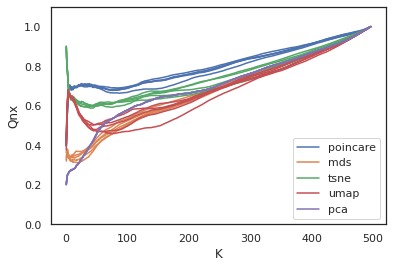

In [50]:
#print(df_results_proj.Qnx.values)

for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    Qnx_mean = []

    for seed in range(5):
        xx = df_results_proj[(df_results_proj.method==clust_meth)&(df_results_proj.seed==seed)].Qnx.values
        xx = xx.squeeze()[()]
        Qnx_mean.append(xx.mean())
        #print(len(xx))
        #fig = px.line(x = range(1,len(xx)+1), y= xx)
        if seed == 0:
            sns.lineplot(range(1,len(xx)+1), xx, color = meth_palette[clust_meth], label = clust_meth)
        else:
            sns.lineplot(range(1,len(xx)+1), xx, color = meth_palette[clust_meth])#, label = clust_meth)
    print(clust_meth, "%2.2f, %2.2f"%(np.mean(Qnx_mean), np.std(Qnx_mean)))

#plt.legend()
plt.xlabel("K")
plt.ylabel("Qnx")
plt.ylim([0,1.1])
plt.savefig("Qnx_global_kinases.pdf")
plt.show()

#fig.show()

In [42]:
print("Local")
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    print(clust_meth, "%2.2f, %2.2f"%(df_results_proj[(df_results_proj.method==clust_meth)].Qlocal.values.mean(), df_results_proj[(df_results_proj.method==clust_meth)].Qlocal.values.std()))
    
print("Global")   
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    print(clust_meth, "%2.2f, %2.2f"%(df_results_proj[(df_results_proj.method==clust_meth)].Qglobal.values.mean(), df_results_proj[(df_results_proj.method==clust_meth)].Qglobal.values.std()))

Local
poincare 0.59, 0.01
mds 0.36, 0.01
tsne 0.90, 0.00
umap 0.56, 0.01
pca 0.37, 0.00
Global
poincare 0.81, 0.01
mds 0.68, 0.01
tsne 0.75, 0.01
umap 0.70, 0.01
pca 0.75, 0.00


In [ ]:
#fig = px.strip(df_results, x='method', y='FMS', color = "true_col")
#fig.show()

In [ ]:
#fig = px.strip(df_results[df_results.true_col=="1_Group"], x='method', y=['corr'])
#fig.show()

In [ ]:
fig = px.strip(df_results[df_results.true_col=="1_Group"], x='method', y=['Qglobal'])
fig.show()

In [ ]:
fig = px.strip(df_results[df_results.true_col=="1_Group"], x='method', y=['Qlocal'])
fig.show()

In [ ]:
fig = px.strip( df_results[(df_results.true_col=="1_Group") & (df_results.method.isin(["poincare","tsne", "umap"])) ], x='method', y=['Kmax'])
fig.show()

### Poincaré distances hyperboliques 

In [ ]:
for cname in ['agglomerative', 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(model.distances, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_poincare"] = clusters
    df_embedding["clust_poincare"] = df_embedding["clust_poincare"].astype("string")
    if remove_others:
        df_noothers = df_embedding[df_embedding[true_col]!="OTHER"]
    print(df_embedding.shape, df_noothers.shape)
    ARS, FMS = get_scores(df_noothers[true_col], df_noothers["clust_poincare"])
    print(scipy.stats.spearmanr(D_raw.ravel(), model.distances.ravel(), axis = 0))

    fig = plot_embedding_interactive(df_embedding, 
                                 labels_name = "clust_poincare",
                                 #second_labels_name = second_labels_name, 
                                 #show_text = show_text,
                                 #labels_text = labels_text,
                                 color_palette = None,
                                 #color_discrete_sequence = px.colors.qualitative.Alphabet,
                                 #color_discrete_map=kinase_palette,
                                 #title = title, 
                                 fontsize = 11)
    fig.show()


        #        scores.append(s)
#        titles.append(t)

#for cname in ['spectral', 'agglomerative', 'kmedoids']:
 #       s, t = detect_cluster(model.get_distances(), 
  #                            n_clusters=nc, clustering_name=cname, k=15, distances='raw')
        #scores.append(s)
        #titles.append(t)

### MDS

In [ ]:
X_cosine = pairwise_distances(features,metric='cosine')
X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = 42).fit_transform(X_cosine)
df_embedding["x1_mds"] = X_mds[:,0]
df_embedding["x2_mds"] = X_mds[:,1]

In [ ]:
D = pairwise_distances(X_mds)
print(D.shape)

for cname in ['agglomerative','spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_mds"] = clusters
    df_embedding["clust_mds"] = df_embedding["clust_mds"].astype("string")
    if remove_others:
        df_noothers = df_embedding[df_embedding[true_col]!="OTHER"]
    print(df_embedding.shape, df_noothers.shape)
    ARS, FMS = get_scores(df_noothers[true_col], df_noothers["clust_mds"])
    print(scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0))

    plt = px.scatter(df_embedding, x = 'x1_mds', y = 'x2_mds',
                     color = df_embedding["clust_mds"],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=kinase_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    plt.update_xaxes(range = [-0.7, 0.7], constrain="domain")
    plt.update_yaxes(range = [-0.7, 0.7], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()
    
    plt = px.scatter(df_embedding, x = 'x1_mds', y = 'x2_mds',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=kinase_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    plt.update_xaxes(range = [-0.7, 0.7], constrain="domain")
    plt.update_yaxes(range = [-0.7, 0.7], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()

### t-SNE

In [ ]:
X_tsne = TSNE(random_state = 42, metric = "cosine", perplexity=k_neigh).fit_transform(features)
df_embedding["x1_tsne"] = X_tsne[:,0]
df_embedding["x2_tsne"] = X_tsne[:,1]

In [ ]:
D = pairwise_distances(X_tsne)
print(D.shape)

for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_tsne"] = clusters
    df_embedding["clust_tsne"] = df_embedding["clust_tsne"].astype("string")
    if remove_others:
        df_noothers = df_embedding[df_embedding[true_col]!="OTHER"]
    print(df_embedding.shape, df_noothers.shape)
    ARS, FMS = get_scores(df_noothers[true_col], df_noothers["clust_tsne"])
    print(scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0))

    plt = px.scatter(df_embedding, x = 'x1_tsne', y = 'x2_tsne',
                     color = df_embedding["clust_tsne"],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=kinase_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-10 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()
    
    plt = px.scatter(df_embedding, x = 'x1_tsne', y = 'x2_tsne',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=kinase_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-60, 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()

### Raw distances

### UMAP

In [ ]:
X_umap = umap.UMAP(random_state = 42, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
df_embedding["x1_umap"] = X_umap[:,0]
df_embedding["x2_umap"] = X_umap[:,1]

In [ ]:
D = pairwise_distances(X_umap)
print(D.shape)

for cname in ['agglomerative', 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_umap"] = clusters
    df_embedding["clust_umap"] = df_embedding["clust_umap"].astype("string")
    if remove_others:
        df_noothers = df_embedding[df_embedding[true_col]!="OTHER"]
    print(df_embedding.shape, df_noothers.shape)
    ARS, FMS = get_scores(df_noothers[true_col], df_noothers["clust_umap"])
    print(scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0))

    plt = px.scatter(df_embedding, x = 'x1_umap', y = 'x2_umap',
                     color = df_embedding["clust_umap"],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=kinase_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-10 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()
    
plt = px.scatter(df_embedding, x = 'x1_umap', y = 'x2_umap',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=kinase_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-60, 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

### PCA

In [ ]:
X_pca = KernelPCA(kernel='linear', random_state = 42).fit_transform(features)
df_embedding["x1_pca"] = X_pca[:,0]
df_embedding["x2_pca"] = X_pca[:,1]

In [ ]:
D = pairwise_distances(X_pca)
print(D.shape)


for cname in ['agglomerative', 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_pca"] = clusters
    df_embedding["clust_pca"] = df_embedding["clust_pca"].astype("string")
    df_noothers = df_embedding[df_embedding[true_col]!="OTHER"]
    print(df_embedding.shape, df_noothers.shape)
    ARS, FMS = get_scores(df_noothers[true_col], df_noothers["clust_pca"])
    
    plt = px.scatter(df_embedding, x = 'x1_pca', y = 'x2_pca',
                     color = df_embedding["clust_pca"],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=kinase_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-10 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()
    


In [35]:
plt = px.scatter(df_embedding, x = 'x1_pca', y = 'x2_pca',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=kinase_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
#plt.update_xaxes(range = [-60, 50], constrain="domain")
#plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()